Preproccesing and converting of the IRIS Dataset to Torch Tensors


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

iris = load_iris()
X, y = iris.data[:, :3], iris.target  # Using only three characteristics

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

Jason SNN Quantization

In [2]:
import torch
import math

class StateQuant(torch.autograd.Function):
    """Wrapper function for state quantization."""
    
    @staticmethod
    def forward(ctx, input_, levels):
        device = input_.device
        levels = levels.to(device)
        size = input_.size()
        input_ = input_.flatten()

        # Broadcast levels along a new dimension equal to the number of levels
        input_expanded = input_.unsqueeze(-1).repeat(1, levels.size(0))

        # Find the closest valid quantization state
        differences = torch.abs(levels - input_expanded)
        idx_match = torch.argmin(differences, dim=-1)
        quant_tensor = levels[idx_match]

        return quant_tensor.reshape(size)

    @staticmethod
    def backward(ctx, grad_output):
        # Straight Through Estimator (STE)
        grad_input = grad_output.clone()
        return grad_input, None

def state_quant(num_bits=8, uniform=True, thr_centered=True, threshold=1,
                lower_limit=0, upper_limit=0.2, multiplier=None):
    """Generate a quantization function with specified parameters."""
    num_levels = 2 ** num_bits  # Total number of quantization levels

    if uniform:
        # Uniform quantization
        levels = torch.linspace(
            -threshold * (1 + lower_limit),
            threshold * (1 + upper_limit),
            num_levels
        )
    else:
        # Non-uniform quantization
        if multiplier is None:
            # Default values based on number of bits
            multiplier = 0.05 + 0.9 * (num_bits - 1) / 15

        if thr_centered:
            # Centered around threshold
            max_val = threshold * (1 + upper_limit)
            min_val = -threshold * (1 + lower_limit)
        else:
            # Centered around zero
            max_val = threshold + threshold * upper_limit
            min_val = -threshold - threshold * lower_limit

        range_vals = torch.logspace(
            start=-multiplier * (num_levels - 1),
            end=0,
            steps=num_levels,
            base=10
        )
        levels = min_val + range_vals * (max_val - min_val)

    def inner(x):
        return StateQuant.apply(x, levels)

    return inner

# Example Usage
if __name__ == "__main__":
    num_bits = 4
    q_func = state_quant(num_bits=num_bits, uniform=True, threshold=5)

    # Sample input tensor
    x = torch.rand(10, 10) * 10 - 5  # Random values between -5 and 5
    quant_x = q_func(x)
    print(quant_x)


tensor([[ 3.8000, -4.2667, -1.3333, -2.8000, -2.0667, -2.8000, -4.2667, -2.0667,
          0.8667, -1.3333],
        [-4.2667, -2.8000, -1.3333, -2.8000,  1.6000, -3.5333, -2.0667, -5.0000,
         -3.5333, -2.8000],
        [ 3.0667, -1.3333, -2.8000,  0.8667, -1.3333, -1.3333, -2.0667, -2.8000,
          3.0667, -3.5333],
        [ 4.5333,  4.5333,  3.8000, -2.8000, -4.2667,  0.8667, -2.0667, -4.2667,
         -1.3333, -3.5333],
        [-2.8000, -0.6000, -2.0667,  1.6000, -0.6000,  0.8667, -0.6000,  3.0667,
         -4.2667, -3.5333],
        [-0.6000,  3.8000,  3.8000,  1.6000,  4.5333, -5.0000, -3.5333,  0.8667,
          0.1333, -3.5333],
        [ 2.3333,  0.1333, -2.8000, -4.2667,  3.0667,  1.6000,  2.3333,  4.5333,
         -1.3333,  4.5333],
        [ 4.5333, -2.8000,  0.1333, -1.3333, -0.6000,  3.0667,  4.5333, -0.6000,
         -2.8000,  1.6000],
        [ 1.6000,  4.5333,  4.5333, -3.5333,  4.5333, -4.2667,  2.3333, -1.3333,
          3.0667, -4.2667],
        [ 3.0667,  

Two layers SNN 

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.nn import QuantLinear
from brevitas.quant import Int8WeightPerTensorFixedPoint
from brevitas.core.quant import QuantType
from brevitas.nn import QuantLinear
from snntorch import functional as SF
from snntorch import functional as SF

beta = 0.9  # Membrane potential decay rate
num_steps = 5  # Number of time steps
hidden = 3 # Number of hidden neurons
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the quantization function for state variables
quant_func = state_quant(num_bits=8, uniform=True, threshold=1)

class IrisNetSNN(nn.Module):
    def __init__(self, timesteps, hidden, beta, quant_bit_width=8):
        super().__init__()
        self.timesteps = timesteps
        self.hidden = hidden
        self.beta = beta

        # Corrected Quantized linear layers using Brevitas
        self.fc1 = QuantLinear(3, hidden, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.fc2 = QuantLinear(hidden, 3, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)


        # Spiking neuron layers with quantized state variables
        self.rlif1 = snn.RLeaky(beta=self.beta, linear_features=self.hidden,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))
        self.rlif2 = snn.RLeaky(beta=self.beta, linear_features=3,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))

    def forward(self, x):
        spk1, mem1 = self.rlif1.init_rleaky()
        spk2, mem2 = self.rlif2.init_rleaky()
        spk_recording = []

        for step in range(self.timesteps):
            x = self.fc1(x)
            spk1, mem1 = self.rlif1(x, spk1, mem1)
            x = self.fc2(spk1)
            spk2, mem2 = self.rlif2(x, spk2, mem2)
            spk_recording.append(spk2)

        return torch.stack(spk_recording)

# Instantiate the model
model = IrisNetSNN(timesteps=num_steps, hidden=hidden, beta=beta).to(device)

# Print quantization parameters of weights
print("First layer weights quantization scale:", model.fc1.quant_weight_scale())
print("Second layer weights quantization scale:", model.fc2.quant_weight_scale())

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Training loop
num_epochs = 15
model.train()
for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        spk = model(data)  # forward-pass
        loss_val = loss_function(spk, targets)  # apply loss
        optimizer.zero_grad()  # zero out gradients
        loss_val.backward()  # calculate gradients
        optimizer.step()  # update weights

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss_val.item()}')

# Testing loop
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        spk = model(data)  # forward-pass
        predicted = spk.sum(dim=0).argmax(1)  # Predict the class with the highest spike count
        correct += (predicted == targets).float().sum()
        total += targets.shape[0]

print(f"Accuracy: {100 * correct / total:.2f}%")

First layer weights quantization scale: tensor(0.0041, grad_fn=<DivBackward0>)
Second layer weights quantization scale: tensor(0.0041, grad_fn=<DivBackward0>)
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.1466666460037231
Epoch 0, Loss: 1.0533334016799927
Epoch 0, Loss: 0.9666666984558105
Epoch 0, Loss: 1.0199999809265137
Epoch 0, Loss: 0.9266666173934937
Epoch 10, Loss: 0.23333331942558289
Epoch 10, Loss: 0.30000001192092896
Epoch 10, Loss: 0.30000001192092896
Epoch 10, Loss: 0.12000000476837158
Epoch 10, Loss: 0.1599999964237213
Epoch 10, Loss: 0.24666666984558105
Epoch 10, Loss: 0.24666666984558105
Epoch 10, Loss: 0.24666666984558105
Epoch 10, Loss: 0.226666659116745
Epoch 10, Loss: 0.2666666805744171
Epoch 10, Loss: 0.30000001192092896
Epoch 10, Loss: 0.226666659116745
Accurac

In [10]:
# Print the actual weights of the first layer
print("First layer weights:", model.fc1.weight.data)

# Print quantized weight scales for the first layer
print("First layer quantization scale:", model.fc1.quant_weight_scale())

# Check the quantized weights range and values
quantized_weights_fc1 = model.fc1.weight.data / model.fc1.quant_weight_scale()
print("Quantized values of first layer (scaled to integer range):", quantized_weights_fc1.int())

# Repeat the process for the second layer
print("Second layer weights:", model.fc2.weight.data)
print("Second layer quantization scale:", model.fc2.quant_weight_scale())
quantized_weights_fc2 = model.fc2.weight.data / model.fc2.quant_weight_scale()
print("Quantized values of second layer (scaled to integer range):", quantized_weights_fc2.int())


First layer weights: tensor([[ 0.0671, -1.4193,  0.7422],
        [-0.6671,  1.0212, -1.6469],
        [-0.7211,  0.0834, -0.7510]])
First layer quantization scale: tensor(0.0130, grad_fn=<DivBackward0>)
Quantized values of first layer (scaled to integer range): tensor([[   5, -109,   57],
        [ -51,   78, -127],
        [ -55,    6,  -57]], dtype=torch.int32)
Second layer weights: tensor([[ 0.3053, -0.1050,  0.8315],
        [ 0.5972, -0.1388, -0.3371],
        [ 0.3062, -0.5545, -0.4493]])
Second layer quantization scale: tensor(0.0065, grad_fn=<DivBackward0>)
Quantized values of second layer (scaled to integer range): tensor([[ 46, -16, 127],
        [ 91, -21, -51],
        [ 46, -84, -68]], dtype=torch.int32)


Three Layers SNN

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.nn import QuantLinear
from brevitas.quant import Int8WeightPerTensorFixedPoint
from brevitas.core.quant import QuantType
from brevitas.nn import QuantLinear
from snntorch import functional as SF
from snntorch import functional as SF

beta = 0.9  # Membrane potential decay rate
num_steps = 3 # Number of time steps
hidden = 3 # Number of hidden neurons
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the quantization function for state variables
quant_func = state_quant(num_bits=8, uniform=True, threshold=1)

class IrisNetSNN(nn.Module):
    def __init__(self, timesteps, hidden, beta, quant_bit_width=8):
        super().__init__()
        self.timesteps = timesteps
        self.hidden = hidden
        self.beta = beta

        # Corrected Quantized linear layers using Brevitas
        self.fc1 = QuantLinear(3, hidden, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
                # Spiking neuron layers with quantized state variables
        self.rlif1 = snn.RLeaky(beta=self.beta, linear_features=self.hidden,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))
        
        
        self.fc2 = QuantLinear(hidden, 3, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif2 = snn.RLeaky(beta=self.beta, linear_features=3,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))
        
                
        self.fc3 = QuantLinear(hidden, 3, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif3 = snn.RLeaky(beta=self.beta, linear_features=3,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))

    def forward(self, x):
        spk1, mem1 = self.rlif1.init_rleaky()
        spk2, mem2 = self.rlif2.init_rleaky()
        spk3, mem3 = self.rlif3.init_rleaky()
        spk_recording = []

        for step in range(self.timesteps):
            x = self.fc1(x)
            spk1, mem1 = self.rlif1(x, spk1, mem1)
            x = self.fc2(spk1)
            spk2, mem2 = self.rlif2(x, spk2, mem2)
            x = self.fc3(spk2)
            spk3, mem3 = self.rlif3(x, spk3, mem3)
            spk_recording.append(spk3)

        return torch.stack(spk_recording)

# Instantiate the model
model = IrisNetSNN(timesteps=num_steps, hidden=hidden, beta=beta).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Training loop
num_epochs = 65
model.train()
for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        spk = model(data)  
        loss_val = loss_function(spk, targets)  # apply loss
        optimizer.zero_grad()  # zero out gradients
        loss_val.backward()  # calculate gradients
        optimizer.step()  # update weights

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss_val.item()}')

# Testing loop
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        spk = model(data)  # forward-pass
        predicted = spk.sum(dim=0).argmax(1)  # Predict the class with the highest spike count
        correct += (predicted == targets).float().sum()
        total += targets.shape[0]

print(f"Accuracy: {100 * correct / total:.2f}%")

Epoch 0, Loss: 0.7111111283302307
Epoch 0, Loss: 0.6222222447395325
Epoch 0, Loss: 0.6222222447395325
Epoch 0, Loss: 0.5
Epoch 0, Loss: 0.7111111283302307
Epoch 0, Loss: 0.5333333611488342
Epoch 0, Loss: 0.5
Epoch 0, Loss: 0.3777777850627899
Epoch 0, Loss: 0.42222222685813904
Epoch 0, Loss: 0.5111110806465149
Epoch 0, Loss: 0.3333333432674408
Epoch 0, Loss: 0.2888889014720917
Epoch 10, Loss: 0.3333333432674408
Epoch 10, Loss: 0.3333333432674408
Epoch 10, Loss: 0.2222222238779068
Epoch 10, Loss: 0.35555556416511536
Epoch 10, Loss: 0.46666666865348816
Epoch 10, Loss: 0.3333333432674408
Epoch 10, Loss: 0.31111112236976624
Epoch 10, Loss: 0.4000000059604645
Epoch 10, Loss: 0.35555556416511536
Epoch 10, Loss: 0.4000000059604645
Epoch 10, Loss: 0.35555556416511536
Epoch 10, Loss: 0.3333333432674408
Epoch 20, Loss: 0.13333334028720856
Epoch 20, Loss: 0.20000000298023224
Epoch 20, Loss: 0.17777778208255768
Epoch 20, Loss: 0.1111111119389534
Epoch 20, Loss: 0.18888889253139496
Epoch 20, Loss: 0

In [48]:
# Print the actual weights of the first layer
print("First layer weights:", model.fc1.weight.data)

# Print quantized weight scales for the first layer
print("First layer quantization scale:", model.fc1.quant_weight_scale())

# Check the quantized weights range and values for the first layer
quantized_weights_fc1 = model.fc1.weight.data / model.fc1.quant_weight_scale()
print("Quantized values of first layer (scaled to integer range):", quantized_weights_fc1.int())

# Repeat the process for the second layer
print("Second layer weights:", model.fc2.weight.data)
print("Second layer quantization scale:", model.fc2.quant_weight_scale())
quantized_weights_fc2 = model.fc2.weight.data / model.fc2.quant_weight_scale()
print("Quantized values of second layer (scaled to integer range):", quantized_weights_fc2.int())

# Now, do the same for the third layer
print("Third layer weights:", model.fc3.weight.data)
print("Third layer quantization scale:", model.fc3.quant_weight_scale())
quantized_weights_fc3 = model.fc3.weight.data / model.fc3.quant_weight_scale()
print("Quantized values of third layer (scaled to integer range):", quantized_weights_fc3.int())


First layer weights: tensor([[ 0.3319,  0.0023, -1.8729],
        [ 1.3750, -0.3160,  2.2557],
        [ 0.7740, -1.4192,  1.0920]])
First layer quantization scale: tensor(0.0178, grad_fn=<DivBackward0>)
Quantized values of first layer (scaled to integer range): tensor([[  18,    0, -105],
        [  77,  -17,  127],
        [  43,  -79,   61]], dtype=torch.int32)
Second layer weights: tensor([[ 1.2153, -0.8578,  0.6429],
        [ 0.8419, -1.3125, -0.9664],
        [ 0.7372, -0.6953, -1.2628]])
Second layer quantization scale: tensor(0.0103, grad_fn=<DivBackward0>)
Quantized values of second layer (scaled to integer range): tensor([[ 117,  -82,   62],
        [  81, -127,  -93],
        [  71,  -67, -122]], dtype=torch.int32)
Third layer weights: tensor([[-0.0359,  0.3920,  0.5185],
        [ 0.4844,  0.2210, -0.4437],
        [-0.4316, -0.2461, -0.7006]])
Third layer quantization scale: tensor(0.0055, grad_fn=<DivBackward0>)
Quantized values of third layer (scaled to integer range): 

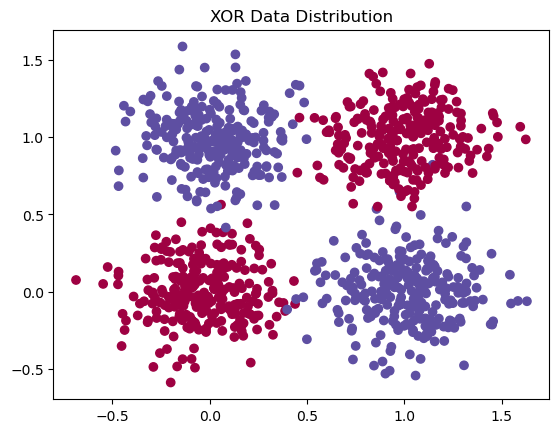

In [50]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to create XOR data
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers, labels):
        points = np.random.normal(loc=center, scale=0.2, size=(n_points//4, 2))
        points_labels = np.hstack((points, label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data, points_labels))
    return data[:, :2], data[:, 2]

X, y = make_xor(1000)
y = y.astype(np.int64)

# Splitting data into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=49) 

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader instances
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Visualization of the XOR data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.title("XOR Data Distribution")
plt.show()


In [56]:
import torch.nn as nn
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.quant import Int8WeightPerTensorFixedPoint
from brevitas.core.quant import QuantType

class IrisNetSNN(nn.Module):
    def __init__(self, timesteps, hidden, beta, quant_bit_width=8):
        super(IrisNetSNN, self).__init__()
        self.timesteps = timesteps
        self.hidden = hidden
        self.beta = beta

        # Define Quantized linear layers using Brevitas
        self.fc1 = QuantLinear(2, hidden, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif1 = snn.Leaky(beta=self.beta, learn_beta=True)
        
        self.fc2 = QuantLinear(hidden, hidden, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif2 = snn.Leaky(beta=self.beta, learn_beta=True)

        self.fc3 = QuantLinear(hidden, 2, bias=True, bit_width=quant_bit_width,  # Note: Output is 2 for binary classification
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif3 = snn.Leaky(beta=self.beta, learn_beta=True)

    def forward(self, x):
        mem1 = self.rlif1.init_leaky()
        spk1 = torch.zeros_like(mem1)
        
        mem2 = self.rlif2.init_leaky()
        spk2 = torch.zeros_like(mem2)
        
        mem3 = self.rlif3.init_leaky()
        spk3 = torch.zeros_like(mem3)

        for step in range(self.timesteps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.rlif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.rlif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.rlif3(cur3, mem3)

        return spk3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IrisNetSNN(timesteps=3, hidden=3, beta=0.9).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

for epoch in range(30):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")



Test Accuracy: 95.00%


In [57]:
# Print the actual weights of the first layer
print("First layer weights:", model.fc1.weight.data)

# Print quantized weight scales for the first layer
print("First layer quantization scale:", model.fc1.quant_weight_scale())

# Check the quantized weights range and values for the first layer
quantized_weights_fc1 = model.fc1.weight.data / model.fc1.quant_weight_scale()
print("Quantized values of first layer (scaled to integer range):", quantized_weights_fc1.int())

# Repeat the process for the second layer
print("Second layer weights:", model.fc2.weight.data)
print("Second layer quantization scale:", model.fc2.quant_weight_scale())
quantized_weights_fc2 = model.fc2.weight.data / model.fc2.quant_weight_scale()
print("Quantized values of second layer (scaled to integer range):", quantized_weights_fc2.int())

# Now, do the same for the third layer
print("Third layer weights:", model.fc3.weight.data)
print("Third layer quantization scale:", model.fc3.quant_weight_scale())
quantized_weights_fc3 = model.fc3.weight.data / model.fc3.quant_weight_scale()
print("Quantized values of third layer (scaled to integer range):", quantized_weights_fc3.int())


First layer weights: tensor([[-1.3135, -0.7997],
        [-1.3320,  1.1354],
        [ 0.4835,  1.0735]])
First layer quantization scale: tensor(0.0105, grad_fn=<DivBackward0>)
Quantized values of first layer (scaled to integer range): tensor([[-125,  -76],
        [-127,  108],
        [  46,  102]], dtype=torch.int32)
Second layer weights: tensor([[ 1.6750, -1.4686,  1.1606],
        [ 1.6809, -1.6104,  1.2953],
        [ 1.2187, -1.9598,  0.8982]])
Second layer quantization scale: tensor(0.0154, grad_fn=<DivBackward0>)
Quantized values of second layer (scaled to integer range): tensor([[ 108,  -95,   75],
        [ 108, -104,   83],
        [  78, -127,   58]], dtype=torch.int32)
Third layer weights: tensor([[ 1.6831,  1.6491,  0.2704],
        [-1.6273, -1.5771, -0.3909]])
Third layer quantization scale: tensor(0.0133, grad_fn=<DivBackward0>)
Quantized values of third layer (scaled to integer range): tensor([[ 127,  124,   20],
        [-122, -119,  -29]], dtype=torch.int32)
